<a href="https://colab.research.google.com/github/kaniarasann/Langchain/blob/main/05_routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!pip install langchain langgraph langchain_groq pydantic

In [66]:
from typing import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessageChunk

In [67]:
class Route(BaseModel):
  step:Literal["poem","story","joke"] = Field(description="The next step in routing process")

In [68]:
from langchain_groq import ChatGroq
from google.colab import userdata
groq_key = userdata.get('groq_key')

llm = ChatGroq(api_key=groq_key, model="meta-llama/llama-4-scout-17b-16e-instruct",)

In [69]:
#make sure the llm respons with the argument route we can use the structured output
llm_with_structured_output = llm.with_structured_output(Route)

In [70]:
test_res=llm_with_structured_output.invoke("tell me a joke")

In [71]:
test_res.step

'joke'

In [72]:
from typing import Optional
class State(BaseModel):
  input : Optional[str] =''
  decision: Optional[str]=''
  output: Optional[str]=''



In [73]:
def joke(state:State):
  "Tell me a joke"
  result = llm.invoke("tell me a joke")
  return {"output":result.content}

In [74]:
def story(state:State):
  "Tell me a story"
  result = llm.invoke("tell me a story")
  return {"output":result.content}

In [75]:
def poem(state:State):
  "Tell me a poem"
  result = llm.invoke("tell me a poem")
  return {"output":result.content}

In [76]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda
def router_llm(state:State):
   prompt_template =  PromptTemplate.from_template("Route the input to story,joke,poem based on the following user request:{user}")
   res = prompt_template | llm_with_structured_output
   response = res.invoke({"user":state.input})
   return {"decision":response.step}

def route_desicion(state:State):
  if(state.decision == "story"):
    return "story"
  elif(state.decision == "joke"):
    return "joke"
  elif(state.decision == "poem"):
    return "poem"

In [77]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display, Image

graph = StateGraph(State)
graph.add_node("joke",joke)
graph.add_node("story",story)
graph.add_node("poem",poem)
graph.add_node("router_llm",router_llm)

graph.add_edge(START,"router_llm")
graph.add_conditional_edges("router_llm",route_desicion,{"story":"story","joke":"joke","poem":"poem"})
graph.add_edge("story",END)
graph.add_edge("joke",END)
graph.add_edge("poem",END)

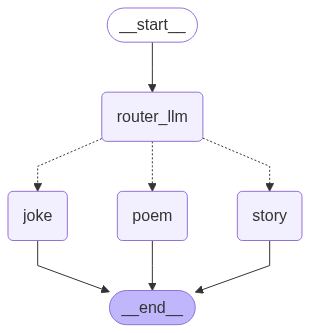

In [78]:
from IPython.display import display, Image
builder = graph.compile()

display(Image(builder.get_graph().draw_mermaid_png()))

In [79]:
state_val = State(input="tell me a joke")
builder_res =builder.invoke(state_val)

In [80]:
router_llm(state_val)

{'decision': 'joke'}

In [85]:
for x in builder_res['output'].split("\n"):
  if x != '':
    print(x)

Here's one:
Why couldn't the bicycle stand up by itself?
(wait for it...)
Because it was two-tired!
How was that? Do you want to hear another one?
